In [1]:
from collections import defaultdict
import logging
from typing import cast, Dict, List, Tuple, Union, Callable
from typing_extensions import get_args, Literal
import sys
import os
import numpy as np
import random 
import seaborn as sns
from PIL import Image
import re
from scipy.stats import spearmanr
from matplotlib.legend_handler import HandlerLine2D
import torch
import torch.nn as nn
import torch.nn.functional as F
import json

import yaml
import argparse
import pandas as pd
from tqdm.notebook import tqdm
from functools import partial

from torch.utils.data import DataLoader, TensorDataset

sys.path.append('/users/sanand14/data/sanand14/learning_dynamics/src/experiments/utils')
sys.path.append('/users/sanand14/data/sanand14/learning_dynamics/src/experiments')

from aheads import create_repeats_dataset
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib
from transformers import BertConfig, BertForMaskedLM, AdamW

import matplotlib.style as style
style.use('ggplot')

from toy_model import TrainingPipeline
from utils.toy_utils import bin_train_loop, create_dataloaders_bin, Probe, POSVocabGenerator, plot_pca_embeddings
from utils.forgetting_utils import AdamEF
from dataclasses import dataclass, field

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch

/users/sanand14/.local/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /oscar/home/sanand14/.local/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator12recordStreamERKNS_7DataPtrENS0_10CUDAStreamE
  warn(f"Failed to load image Python extension: {e}")


[2024-11-17 21:15:30,728] [INFO] [real_accelerator.py:191:get_accelerator] Setting ds_accelerator to cuda (auto detect)


vocab size 10,000, amb 0.10, unif, stop forgetting after 20000

In [2]:
sns.set_theme(context="paper", style="ticks", rc={"lines.linewidth": 2})

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import GPT2Config, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
import random
import numpy as np
from dataclasses import dataclass, field
from typing import List, Callable
from tqdm import tqdm

## Some Run Examples

In [4]:
import itertools

In [5]:
PYTHIA_VOCAB_SIZE = 50277 #50304
N_LAYERS=12
PYTHIA_CHECKPOINTS_OLD = [0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512] + list(range(1000, 143000 + 1, 10000)) + [143000]
PYTHIA_CHECKPOINTS = [512] + list(range(1000, 10000 + 1, 1000))

In [6]:
from transformers import AutoTokenizer, AutoModel

In [7]:
from transformer_lens import HookedTransformer


In [8]:
device = "cuda"

In [9]:
vocabulary = [
        " A",
        " B",
        " C",
        " D",
        " E",
        " F",
        " G",
        " H",
        " I",
        " J",
        " K",
        " L",
        " M",
        " N",
        " O",
        " P",
        " Q",
        " R",
        " S",
        " T",
        " U",
        " V",
        " W",
        " X",
        " Y",
        " Z",
    ]

In [10]:
def logits_to_logit_diff(model, logits, correct_answer, incorrect_answer):
    """Compute logit difference"""
    correct_idx = model.to_single_token(correct_answer)
    incorrect_idx = model.to_single_token(incorrect_answer)
    return logits[0, -1, correct_idx] - logits[0, -1, incorrect_idx]

In [11]:
def generate_abstract_example(vocab_set, idx_1, idx_2, idx_3, nonce=False):
    """Helper function to generate abstract example"""
    item_1 = random.choice([f' [NEW_TOKEN{i}]' for i in range(20)]) if nonce else vocab_set[idx_1]
    item_2 = vocab_set[idx_2]
    item_3 = vocab_set[idx_3]
    
    prompt = (
        f"All{item_1} are{item_2}. "
        + f"All{item_2} are{item_3}. "
        + f"Therefore, all{item_1} are"
    )
    label = item_3
    wrong_label = item_2
    return prompt, label, wrong_label

In [12]:
def behavioral_analysis(
    data_size, model, vocabulary, q_type, correct_label, incorrect_label, device, nonce=False
):
    """Main function"""
    # torch.set_grad_enabled(False)

    data = {
        "clean_x": [],
        "clean_y": [],
        "wrong_y": [],
    }

    for _ in range(data_size):
        vocab_set = np.random.choice(vocabulary, 8, replace=False)
        vocab_set_1 = vocab_set[:4]
        clean_x, clean_y, wrong_y = generate_abstract_example(vocab_set_1, 0, 1, 2, nonce=nonce)
        data["clean_x"].append(clean_x)
        data["clean_y"].append(clean_y)
        data["wrong_y"].append(wrong_y)
    accuracy = []
    total_samples = len(data["clean_x"])
    for i in range(total_samples):

        if i % 25 == 0:
            print(f"Progress: {round(i/total_samples, 3)}")
            
        clean_prompt = data[q_type][i]
        clean_label = data[correct_label][i]
        cf_label = data[incorrect_label][i]

        clean_tokens = model.to_tokens(clean_prompt)
        logits = model(clean_tokens)

        accuracy.append(logits_to_logit_diff(model, logits, clean_label, cf_label) > 0)

    print(f"Model Accuracy: {torch.mean(torch.Tensor(accuracy))}")
    return torch.mean(torch.Tensor(accuracy))


In [18]:
nonce_tokens = [f' [NEW_TOKEN{i}]' for i in range(20)]

In [19]:
def expand_tokenizer(model, nonce_tokens):
    model.tokenizer.add_tokens(nonce_tokens)
    original_num_embeddings, embedding_dim = model.embed.W_E.shape
    new_num_embeddings = original_num_embeddings + len(nonce_tokens)
    
    new_embeddings = torch.nn.Parameter(torch.empty(new_num_embeddings, embedding_dim).to(device))
    with torch.no_grad():
        new_embeddings[:original_num_embeddings] = model.embed.W_E
    
        initializer_range = model.cfg.initializer_range
        print(f"Initializer range: {initializer_range}")
    
        torch.nn.init.normal_(
            new_embeddings[original_num_embeddings:],  # Only initialize new embeddings
            mean=0.0,
            std=initializer_range
        )
    
    model.embed.W_E = new_embeddings

In [10]:
import os
import json
import pandas as pd
import re

def get_df(real_model_ar_path):
    data_list = []
    
    dir_pattern = re.compile(r'^(.*)-step=(\d+)-num_ex=(\d+)$')
    
    for dir_name in os.listdir(real_model_ar_path):
        dir_path = os.path.join(real_model_ar_path, dir_name)
        if os.path.isdir(dir_path):
            match = dir_pattern.match(dir_name)
            if match:
                model_name, step_str, num_ex_str = match.groups()
                step = int(step_str)
                num_ex = int(num_ex_str)
                json_file_path = os.path.join(dir_path, 'model_step_acc.json')
                if os.path.isfile(json_file_path):
                    with open(json_file_path, 'r') as json_file:
                        json_data = json.load(json_file)
                        record = {
                            'model': model_name,
                            'step': step,
                            'num_ex': num_ex,
                        }
                        record.update(json_data)
                        data_list.append(record)
                else:
                    print(f"Warning: {json_file_path} does not exist.")
            else:
                print(f"Warning: Directory name '{dir_name}' does not match the expected pattern.")
    
    df = pd.DataFrame(data_list)
    return df

df1 = get_df('../../outputs/real_model_ar/trial1')
df2 = get_df('../../outputs/real_model_ar/trial2')
df3 = get_df('../../outputs/real_model_ar/trial3')
# df5 = get_df('../../outputs/real_model_ar/trial5')


In [11]:
df_vales = pd.concat([df1, df2, df3]).groupby(['step'])[['clean', 'nonce']].mean()
# df_vales = df5

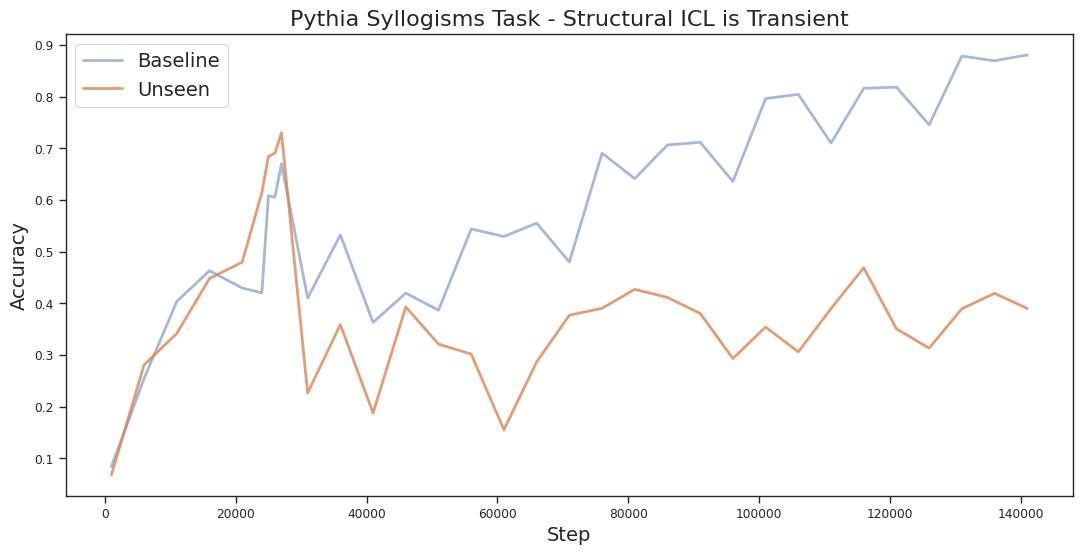

In [13]:
fig, ax = plt.subplots(figsize=(13, 6))
sns.lineplot(data=df_vales.sort_values(by='step'), x='step', y='clean', label='Baseline', alpha=0.5)
sns.lineplot(data=df_vales.sort_values(by='step'), x='step', y='nonce', label='Unseen', alpha=0.8)
ax.legend(fontsize=14)
ax.set_title('Pythia Syllogisms Task - Structural ICL is Transient', fontsize=16)
ax.set_ylabel('Accuracy', fontsize=14)
ax.set_xlabel('Step', fontsize=14)

plt.show()

In [6]:
MODEL = 'EleutherAI/Pythia-1.4B'

In [23]:
model = HookedTransformer.from_pretrained(MODEL, checkpoint_value=26000, device=device)

Using pad_token, but it is not set yet.


Loaded pretrained model EleutherAI/Pythia-1.4B into HookedTransformer


In [24]:
expand_tokenizer(model, nonce_tokens)

Initializer range: 0.017677669529663688


In [25]:
model.tokenizer.encode(random.choice([f' [NEW_TOKEN{i}]' for i in range(20)]))

[50283]

In [ ]:
clean_acc = behavioral_analysis(
        300, model, vocabulary, "clean_x", "clean_y", "wrong_y", device
    ).item()

In [ ]:
clean_acc = behavioral_analysis(
        300, model, vocabulary, "clean_x", "clean_y", "wrong_y", device, nonce=True
    ).item()

# GPT-2 Large Training (See if we can increase the accuracy of this)

In [11]:
def logits_to_probability(tokenizer, logits, correct_answer):
    """Compute the probability of the correct answer"""
    correct_idx = tokenizer.encode(correct_answer)[0]
    
    logits_last = logits[0, -1, :]  # Shape: [vocab_size]
    probs = torch.softmax(logits_last, dim=-1)  # Shape: [vocab_size]
    prob_correct = probs[correct_idx]
    return prob_correct.item()

In [12]:
def generate_abstract_example_t(vocab_set, idx_1, idx_2, idx_3, nonce=False):
    """Helper function to generate abstract example"""
    item_1 = random.choice([f' [NEW_TOKEN{i}]' for i in range(50)]) if nonce else vocab_set[idx_1]
    item_2 = vocab_set[idx_2]
    item_3 = vocab_set[idx_3]
    
    prompt = (
        f"All{item_1} are{item_2}. "
        + f"All{item_2} are{item_3}. "
        + f"Therefore, all{item_1} are"
    )
    label = item_3
    wrong_label = item_2
    # print(prompt, label, wrong_label)
    return prompt, label, wrong_label

In [13]:
def logits_to_logit_diff_t(tokenizer, logits, correct_answer, incorrect_answer):
    """Compute logit difference"""
    correct_idx = tokenizer.encode(correct_answer)[0]
    incorrect_idx = tokenizer.encode(incorrect_answer)[0]
    # print(logits[0, -1, correct_idx], logits[0, -1, incorrect_idx])
    # print(logits_to_probability(tokenizer, logits, correct_answer), logits_to_probability(tokenizer, logits, incorrect_answer))
    # print(logits[0, -1].argmax().item() == correct_idx, logits[0, -1].argmax().item() == incorrect_idx)
    # print(logits[0, -1].argmax().item(), correct_idx, incorrect_idx)
    return logits[0, -1, correct_idx] - logits[0, -1, incorrect_idx]

In [14]:
data_size=300

In [15]:
data_baseline = {
"clean_x": [],
"clean_y": [],
"wrong_y": [],
}
for _ in range(data_size):
    vocab_set = np.random.choice(vocabulary, 8, replace=False)
    vocab_set_1 = vocab_set[:4]
    clean_x, clean_y, wrong_y = generate_abstract_example_t(vocab_set_1, 0, 1, 2, nonce=False)
    data_baseline["clean_x"].append(clean_x)
    data_baseline["clean_y"].append(clean_y)
    data_baseline["wrong_y"].append(wrong_y)

data_nonce = {
"clean_x": [],
"clean_y": [],
"wrong_y": [],
}
for _ in range(data_size):
    vocab_set = np.random.choice(vocabulary, 8, replace=False)
    vocab_set_1 = vocab_set[:4]
    clean_x, clean_y, wrong_y = generate_abstract_example_t(vocab_set_1, 0, 1, 2, nonce=True)
    data_nonce["clean_x"].append(clean_x)
    data_nonce["clean_y"].append(clean_y)
    data_nonce["wrong_y"].append(wrong_y)

In [16]:
def behavioral_analysis_t(
    model, tokenizer, vocabulary, q_type, correct_label, incorrect_label, device, nonce=False, verbose=True
):
    """Main function"""
    # torch.set_grad_enabled(False)
    if nonce:
        data = data_nonce
    else:
        data = data_baseline
    accuracy = []
    total_samples = len(data["clean_x"])
    for i in range(total_samples):

        if i % 50 == 0 and verbose:
            print(f"Progress: {round(i/total_samples, 3)}")
            
        clean_prompt = data[q_type][i]
        clean_label = data[correct_label][i]
        cf_label = data[incorrect_label][i]
        clean_tokens = tokenizer.encode(clean_prompt, return_tensors="pt").to(model.device)
        # print(clean_tokens)
        with torch.no_grad():
            logits = model(clean_tokens).logits
        # print(logits.logits.shape)
        
        accuracy.append(logits_to_logit_diff_t(tokenizer, logits, clean_label, cf_label) > 0)
    if verbose:
        print(f"Model Accuracy: {torch.mean(torch.Tensor(accuracy))}")
    return torch.mean(torch.Tensor(accuracy))


In [17]:
device="cuda"

In [18]:
import os
os.environ["WANDB_SILENT"] = "true"
os.environ["WANDB_CONSOLE"] = "off"
os.environ["WANDB_MODE"] = "disabled"

In [19]:
os.makedirs('../../outputs/gpt2-wikitext', exist_ok=True)

In [20]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch
import torch.nn as nn

model_name = "gpt2-large"
model = GPT2LMHeadModel.from_pretrained(model_name).to(device)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

In [21]:
assert model.config.tie_word_embeddings, "The model does not have tied embeddings."

In [22]:
# old_embeddings = model.transformer.wte
# vocab_size, embedding_dim = old_embeddings.weight.shape

In [23]:
# new_vocab_size = vocab_size + 20
# new_embeddings = nn.Embedding(new_vocab_size, embedding_dim).to(device)
# with torch.no_grad():
#     new_embeddings.weight[:vocab_size] = old_embeddings.weight
# model.transformer.wte = new_embeddings
# model.lm_head.weight = model.transformer.wte.weight
# Tie the unembedding layer (output logits layer) to the new embedding matrix

tokenizer.add_tokens([f" [NEW_TOKEN{i}]" for i in range(50)])
model.resize_token_embeddings(len(tokenizer), pad_to_multiple_of=16)
print(f"Updated vocab size: {len(tokenizer)}, Embedding matrix size: {model.transformer.wte.weight.shape}")

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Updated vocab size: 50307, Embedding matrix size: torch.Size([50320, 1280])


In [24]:
tokenizer.pad_token = tokenizer.eos_token

In [25]:
clean_acc = behavioral_analysis_t(
        model, tokenizer, vocabulary, "clean_x", "clean_y", "wrong_y", device, nonce=False
    ).item()

Progress: 0.0
Progress: 0.167
Progress: 0.333
Progress: 0.5
Progress: 0.667
Progress: 0.833
Model Accuracy: 0.903333306312561


In [26]:
tokenizer.encode(' [NEW_TOKEN1]', return_tensors="pt").to(device)

tensor([[50258]], device='cuda:0')

In [27]:
clean_acc = behavioral_analysis_t(
        model, tokenizer, vocabulary, "clean_x", "clean_y", "wrong_y", device, nonce=True
    ).item()

Progress: 0.0
Progress: 0.167
Progress: 0.333
Progress: 0.5
Progress: 0.667
Progress: 0.833
Model Accuracy: 0.02666666731238365


----

Put a reference to the generation task - p hard to do this for temporary forgetting

Can consider try doing this for a small GPT model – (completely random, their eval); try fine-tuning w/ embedding dropout and then eval.
[X, X1, X2, X1, X3] - softer version; 


Copy of the initial embedding matrix
1. Embedding matrix: 
2. X1-> random vector
3. X2-> X2_2
4. After backprop
5. Replace random vector -> X1
6. Reset embedding matrix -> back to before FT


– A is B. B is C. Therefore A is _.
– Wikitext few thousand sentences - replace some of the tokens w/ random (regular Next Word Prediction objective)
– then go back and test on the syllogism


----

In [28]:
from transformers import DataCollatorForLanguageModeling

In [29]:
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments
from datasets import load_dataset

dataset = load_dataset('wikitext', 'wikitext-2-raw-v1')
def filter_empty_examples(example):
    return example['text'].strip() != ''
    
filtered_dataset = dataset.filter(filter_empty_examples)

def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, max_length=512)
    
tokenized_datasets = filtered_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["text"],
)

def filter_short_examples(example):
    return len(example['input_ids']) > 0
    
tokenized_datasets = tokenized_datasets.filter(filter_short_examples)
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,
)

train_loader = DataLoader(
    tokenized_datasets['train'],
    batch_size=2,  # Adjust batch size as needed
    shuffle=False,
    collate_fn=data_collator,
)

Map:   0%|          | 0/2891 [00:00<?, ? examples/s]

Map:   0%|          | 0/23767 [00:00<?, ? examples/s]

Map:   0%|          | 0/2461 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2891 [00:00<?, ? examples/s]

Filter:   0%|          | 0/23767 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2461 [00:00<?, ? examples/s]

In [30]:
import torch.optim as optim
from tqdm.notebook import tqdm

In [31]:
WARMUP_STEPS = 500
total_steps = len(train_loader)
optimizer = optim.AdamW(model.parameters(), lr=3e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=WARMUP_STEPS, num_training_steps=total_steps)

num_epochs = 1  
initializer_range = model.config.initializer_range

In [32]:
# Training loop
metrics = {"baseline_acc": {}, 
          "nonce_acc": {}}
for i, batch in enumerate(tqdm(train_loader)):
    if i > 2000:
        break
    model.train()
    batch = {k: v.to(device) for k, v in batch.items()}
    
    original_embeddings = model.transformer.wte.weight.data.clone()
    unique_tokens = torch.unique(batch['input_ids'])
    unique_tokens = unique_tokens[unique_tokens != tokenizer.pad_token_id]
    
    mask_prob = 0.1
    mask = torch.rand(len(unique_tokens), device=device) < mask_prob
    tokens_to_replace = unique_tokens[mask]

    with torch.no_grad():
        random_embeddings = torch.normal(
            mean=0.0,
            std=initializer_range,
            size=(tokens_to_replace.size(0), model.transformer.wte.weight.shape[1]),
            device=device,
        )
        model.transformer.wte.weight.data[tokens_to_replace] = random_embeddings
    assert torch.all(model.transformer.wte.weight.data == model.lm_head.weight.data).item()
    
    
    outputs = model(**batch)
    loss = outputs.loss
    
    loss.backward()

    with torch.no_grad():
        model.transformer.wte.weight.data[tokens_to_replace] = original_embeddings[tokens_to_replace]
    
    assert torch.all(model.transformer.wte.weight.data == model.lm_head.weight.data).item()
    assert torch.all(model.transformer.wte.weight.data == original_embeddings).item()

    model.transformer.wte.weight.grad = None
    
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

    if i % 100 == 0:
        model.eval()
        baseline_acc = behavioral_analysis_t(
            model, tokenizer, vocabulary, "clean_x", "clean_y", "wrong_y", device, nonce=False, verbose=False
        ).item()
        nonce_acc = behavioral_analysis_t(
            model, tokenizer, vocabulary, "clean_x", "clean_y", "wrong_y", device, nonce=True, verbose=False
        ).item()
        metrics["baseline_acc"][i] = baseline_acc
        metrics["nonce_acc"][i] = nonce_acc
        print(f"Step {i}, Baseline Acc: {baseline_acc}, Nonce Acc: {nonce_acc}")
        json.dump(metrics, open(os.path.join('../../outputs/gpt2-wikitext', "model_step_acc_new.json"), "w"))

  0%|          | 0/11884 [00:00<?, ?it/s]

Step 0, Baseline Acc: 0.903333306312561, Nonce Acc: 0.02666666731238365
Step 100, Baseline Acc: 0.8133333325386047, Nonce Acc: 0.07333333045244217
Step 200, Baseline Acc: 0.7866666913032532, Nonce Acc: 0.3733333349227905
Step 300, Baseline Acc: 0.7400000095367432, Nonce Acc: 0.4699999988079071
Step 400, Baseline Acc: 0.6833333373069763, Nonce Acc: 0.5199999809265137
Step 500, Baseline Acc: 0.7766666412353516, Nonce Acc: 0.7266666889190674
Step 600, Baseline Acc: 0.550000011920929, Nonce Acc: 0.5333333611488342
Step 700, Baseline Acc: 0.6966666579246521, Nonce Acc: 0.699999988079071
Step 800, Baseline Acc: 0.5, Nonce Acc: 0.5333333611488342
Step 900, Baseline Acc: 0.6966666579246521, Nonce Acc: 0.79666668176651
Step 1000, Baseline Acc: 0.746666669845581, Nonce Acc: 0.7300000190734863
Step 1100, Baseline Acc: 0.8066666722297668, Nonce Acc: 0.6100000143051147
Step 1200, Baseline Acc: 0.8566666841506958, Nonce Acc: 0.6466666460037231
Step 1300, Baseline Acc: 0.7200000286102295, Nonce Acc: 

In [46]:
json.dump(df_metrics.set_index('step').to_dict(), open(os.path.join('../../outputs/gpt2-wikitext', "model_step_acc_new.json"), "w"))

In [49]:
metrics = json.load(open(os.path.join('../../outputs/gpt2-wikitext', "model_step_acc_new.json"), "r"))

In [52]:
df_metrics = pd.DataFrame(metrics)

In [57]:
df_metrics.step = df_metrics.step.astype(int)

In [66]:
df_metrics['step'] =  df_metrics.step.astype(int)

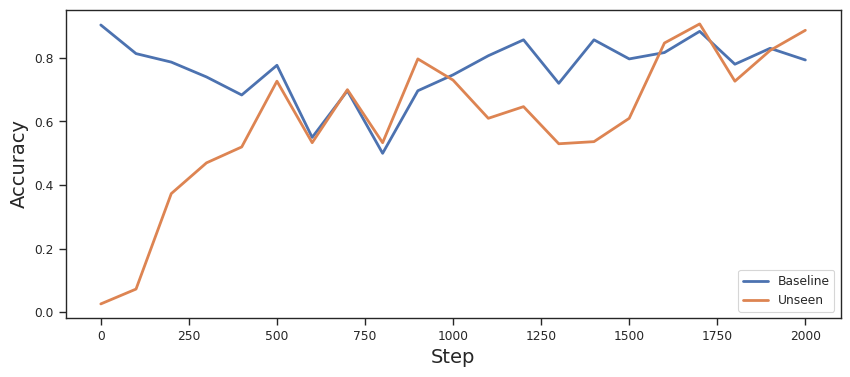

In [33]:
df_metrics = pd.DataFrame(metrics)
df_metrics = df_metrics.reset_index()
df_metrics.columns = ["step", "baseline_acc", "nonce_acc"]
df_metrics.step = df_metrics.step.astype(int)

fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=df_metrics, x="step", y="baseline_acc", label="Baseline", ax=ax)
sns.lineplot(data=df_metrics, x="step", y="nonce_acc", label="Unseen", ax=ax)
ax.set_ylabel("Accuracy", fontsize=14)
ax.set_xlabel("Step", fontsize=14)
plt.show()

In [57]:
parsed_data = []
for line in str_metrics.strip().split("\n"):
    step_info = line.split(", ")
    step = int(step_info[0].split(" ")[1])
    baseline_acc = float(step_info[1].split(": ")[1])
    nonce_acc = float(step_info[2].split(": ")[1])
    parsed_data.append({
        "step": step,
        "baseline_acc": baseline_acc,
        "nonce_acc": nonce_acc
    })

# Save the parsed data as a JSON file
output_file = "../../outputs/gpt2-wikitext/parsed_accuracy_data.json"
with open(output_file, "w") as json_file:
    json.dump(parsed_data, json_file, indent=4)

In [79]:
parsed_data = json.load(open("../../outputs/gpt2-wikitext/parsed_accuracy_data.json", "r"))

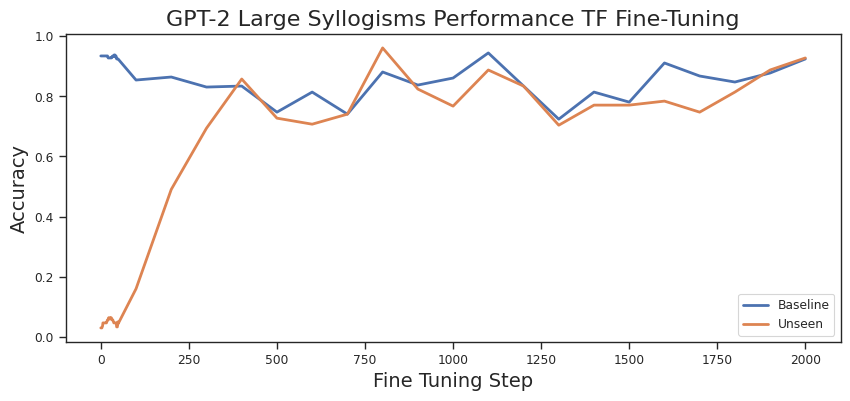

In [86]:
df_metrics = pd.DataFrame(parsed_data)

fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=df_metrics, x="step", y="baseline_acc", label="Baseline", ax=ax)
sns.lineplot(data=df_metrics, x="step", y="nonce_acc", label="Unseen", ax=ax)
ax.set_ylabel("Accuracy", fontsize=14)
ax.set_xlabel("Fine Tuning Step", fontsize=14)
ax.set_title("GPT-2 Large Syllogisms Performance TF Fine-Tuning", fontsize=16)
plt.show()

In [74]:
# Save the trained model and tokenizer
tokenizer.save_pretrained('../../outputs/gpt2-wikitext')
model.save_pretrained('../../outputs/gpt2-wikitext')


In [51]:
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50320, 1280)
    (wpe): Embedding(1024, 1280)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-35): 36 x GPT2Block(
        (ln_1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=3840, nx=1280)
          (c_proj): Conv1D(nf=1280, nx=1280)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=5120, nx=1280)
          (c_proj): Conv1D(nf=1280, nx=5120)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1280, out_features=50320, bias=False)
)

In [52]:
baseline_acc = behavioral_analysis_t(
                300, model, tokenizer, vocabulary, "clean_x", "clean_y", "wrong_y", device, nonce=False
            ).item()

Progress: 0.0
Progress: 0.167
Progress: 0.333
Progress: 0.5
Progress: 0.667
Progress: 0.833
Model Accuracy: 0.9599999785423279


In [53]:
nonce_acc = behavioral_analysis_t(
                300, model, tokenizer, vocabulary, "clean_x", "clean_y", "wrong_y", device, nonce=True
            ).item()

Progress: 0.0
Progress: 0.167
Progress: 0.333
Progress: 0.5
Progress: 0.667
Progress: 0.833
Model Accuracy: 0.9700000286102295
